TV-Regularized Sparse-View CT Reconstruction (Multiple Projectors)
==================================================================

This example demonstrates solution of a sparse-view CT reconstruction
problem with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and
$\mathbf{x}$ is the desired image. The solution is computed and compared
for all three 2D CT projectors available in scico, using a sinogram
computed with the astra projector.

In [1]:
import numpy as np

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray import XRayTransform2D, astra, svmbir
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(1234)
x_gt = snp.array(discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N))

det_count = int(N * 1.05 / np.sqrt(2.0))
det_spacing = np.sqrt(2)

Define CT geometry and construct array of (approximately) equivalent projectors.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
projectors = {
    "astra": astra.XRayTransform2D(
        x_gt.shape, det_count, det_spacing, angles - np.pi / 2.0
    ),  # astra
    "svmbir": svmbir.XRayTransform(
        x_gt.shape, 2 * np.pi - angles, det_count, delta_pixel=1.0, delta_channel=det_spacing
    ),  # svmbir
    "scico": XRayTransform2D((N, N), angles, det_count=det_count, dx=1 / det_spacing),  # scico
}

Compute common sinogram using astra projector.

In [4]:
A = projectors["astra"]
noise = np.random.normal(size=(n_projection, det_count)).astype(np.float32)
y = A @ x_gt + 2.0 * noise

Construct initial solution for regularized problem.

In [5]:
x0 = A.fbp(y)

Solve the same problem using the different projectors.

In [6]:
print(f"Solving on {device_info()}")
x_rec, hist = {}, {}
for p in projectors.keys():
    print(f"\nSolving with {p} projector")

    # Set up ADMM solver object.
    λ = 2e1  # L1 norm regularization parameter
    ρ = 1e3  # ADMM penalty parameter
    maxiter = 100  # number of ADMM iterations
    cg_tol = 1e-4  # CG relative tolerance
    cg_maxiter = 50  # maximum CG iterations per ADMM iteration

    # The append=0 option makes the results of horizontal and vertical
    # finite differences the same shape, which is required for the L21Norm,
    # which is used so that g(Cx) corresponds to isotropic TV.
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    g = λ * functional.L21Norm()
    A = projectors[p]
    f = loss.SquaredL2Loss(y=y, A=A)

    # Set up the solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
        itstat_options={"display": True, "period": 5},
    )

    # Run the solver.
    solver.solve()
    hist[p] = solver.itstat_object.history(transpose=True)
    x_rec[p] = solver.x

    if p == "scico":
        x_rec[p] = x_rec[p] * det_spacing  # to match ASTRA's scaling

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

Solving with astra projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  4.26e+00  3.126e+06  3.234e+02  4.223e+04     26  9.840e-05


   5  1.36e+01  7.175e+05  5.847e+01  1.973e+04     13  8.932e-05


  10  2.19e+01  3.556e+05  5.932e+01  1.011e+04     14  9.504e-05


  15  3.08e+01  2.880e+05  3.661e+01  4.752e+03     13  9.403e-05


  20  3.81e+01  2.724e+05  2.090e+01  2.496e+03     11  8.806e-05


  25  4.41e+01  2.669e+05  1.270e+01  1.569e+03      9  9.109e-05


  30  4.93e+01  2.643e+05  8.917e+00  1.127e+03      6  9.951e-05


  35  5.35e+01  2.627e+05  6.739e+00  9.162e+02      5  9.422e-05


  40  5.71e+01  2.618e+05  5.155e+00  7.655e+02      5  9.111e-05


  45  5.99e+01  2.611e+05  4.461e+00  6.199e+02      4  9.366e-05


  50  6.27e+01  2.606e+05  2.929e+00  5.885e+02      3  9.628e-05


  55  6.54e+01  2.602e+05  2.398e+00  5.285e+02      3  9.364e-05


  60  6.82e+01  2.599e+05  2.486e+00  4.727e+02      3  8.654e-05


  65  7.08e+01  2.596e+05  2.523e+00  4.316e+02      2  9.976e-05


  70  7.30e+01  2.595e+05  2.600e+00  3.779e+02      2  9.815e-05


  75  7.52e+01  2.593e+05  2.220e+00  3.656e+02      2  8.984e-05


  80  7.76e+01  2.592e+05  2.836e+00  2.837e+02      2  9.606e-05


  85  7.98e+01  2.591e+05  2.719e+00  2.675e+02      2  9.314e-05


  90  8.20e+01  2.590e+05  2.623e+00  2.527e+02      2  8.890e-05


  95  8.41e+01  2.589e+05  1.909e+00  1.610e+02      1  9.958e-05


  99  8.56e+01  2.588e+05  1.945e+00  1.551e+02      1  9.738e-05

Solving with svmbir projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.71e+01  2.586e+06  3.234e+02  3.949e+04     25  8.965e-05


   5  6.93e+01  7.197e+05  5.330e+01  1.905e+04     12  8.668e-05


  10  1.21e+02  3.892e+05  5.719e+01  1.046e+04     13  9.341e-05


  15  1.74e+02  3.076e+05  3.786e+01  5.273e+03     12  9.515e-05


  20  2.21e+02  2.849e+05  2.289e+01  2.858e+03     10  9.480e-05


  25  2.61e+02  2.766e+05  1.443e+01  1.778e+03      8  9.677e-05


  30  2.94e+02  2.726e+05  9.518e+00  1.288e+03      7  9.711e-05


  35  3.23e+02  2.704e+05  7.060e+00  1.002e+03      6  9.883e-05


  40  3.49e+02  2.690e+05  5.275e+00  8.450e+02      5  9.524e-05


  45  3.70e+02  2.681e+05  4.741e+00  6.902e+02      4  9.149e-05


  50  3.91e+02  2.674e+05  4.195e+00  6.055e+02      4  9.035e-05


  55  4.09e+02  2.669e+05  2.799e+00  5.656e+02      3  8.644e-05


  60  4.26e+02  2.665e+05  2.249e+00  5.214e+02      3  8.928e-05


  65  4.44e+02  2.661e+05  1.979e+00  4.799e+02      3  8.460e-05


  70  4.62e+02  2.658e+05  2.180e+00  4.369e+02      2  9.912e-05


  75  4.76e+02  2.657e+05  2.152e+00  4.012e+02      2  8.675e-05


  80  4.91e+02  2.655e+05  2.637e+00  3.341e+02      2  9.437e-05


  85  5.06e+02  2.653e+05  2.719e+00  2.969e+02      2  9.596e-05


  90  5.20e+02  2.652e+05  2.623e+00  2.779e+02      2  8.867e-05


  95  5.35e+02  2.651e+05  2.543e+00  2.655e+02      2  9.015e-05


  99  5.45e+02  2.650e+05  2.276e+00  1.868e+02      1  9.215e-05

Solving with scico projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.99e-01  3.079e+06  3.234e+02  5.944e+04     42  8.614e-05


   5  6.51e-01  5.174e+05  6.500e+01  1.905e+04     14  9.782e-05


  10  9.69e-01  2.684e+05  5.861e+01  9.087e+03     16  9.426e-05


  15  1.26e+00  2.199e+05  3.387e+01  4.208e+03     13  9.100e-05


  20  1.52e+00  2.076e+05  1.920e+01  2.235e+03     12  7.446e-05


  25  1.70e+00  2.032e+05  1.193e+01  1.395e+03      4  9.871e-05
  30  1.86e+00  2.011e+05  8.794e+00  1.050e+03      8  8.938e-05


  35  2.00e+00  1.998e+05  5.962e+00  8.597e+02      3  9.413e-05


  40  2.12e+00  1.990e+05  4.145e+00  7.292e+02      4  9.688e-05
  45  2.23e+00  1.985e+05  3.528e+00  6.136e+02      4  8.594e-05


  50  2.33e+00  1.980e+05  2.978e+00  5.747e+02      3  9.247e-05
  55  2.43e+00  1.977e+05  3.287e+00  4.853e+02      3  8.694e-05


  60  2.53e+00  1.975e+05  3.191e+00  3.436e+02      2  9.745e-05
  65  2.62e+00  1.974e+05  3.428e+00  2.895e+02      2  7.706e-05
  70  2.71e+00  1.972e+05  3.331e+00  2.640e+02      2  8.096e-05


  75  2.79e+00  1.971e+05  3.203e+00  2.434e+02      2  7.129e-05
  80  2.88e+00  1.970e+05  3.082e+00  2.260e+02      2  7.379e-05


  85  2.96e+00  1.969e+05  2.964e+00  2.115e+02      2  6.736e-05
  90  3.05e+00  1.968e+05  2.862e+00  1.991e+02      2  6.843e-05
  95  3.14e+00  1.968e+05  2.764e+00  1.876e+02      2  6.369e-05


  99  3.22e+00  1.967e+05  2.691e+00  1.795e+02      2  6.229e-05


Compare reconstruction results.

In [7]:
print("Reconstruction SNR:")
for p in projectors.keys():
    print(f"  {(p + ':'):7s}  {metric.snr(x_gt, x_rec[p]):5.2f} dB")

Reconstruction SNR:


  astra:   11.01 dB
  svmbir:  11.13 dB
  scico:   10.95 dB


Display sinogram.

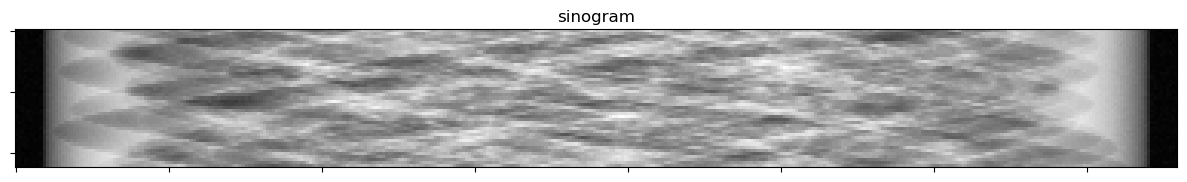

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=1, figsize=(15, 3))
plot.imview(y, title="sinogram", fig=fig, ax=ax)
fig.show()

Plot convergence statistics.

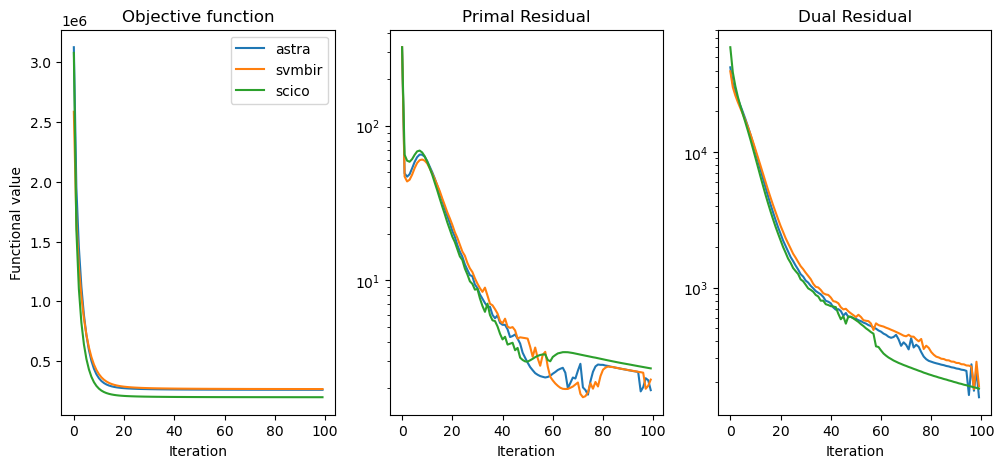

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(12, 5))
plot.plot(
    np.vstack([hist[p].Objective for p in projectors.keys()]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=projectors.keys(),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack([hist[p].Prml_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.vstack([hist[p].Dual_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[2],
)
fig.show()

Show the recovered images.

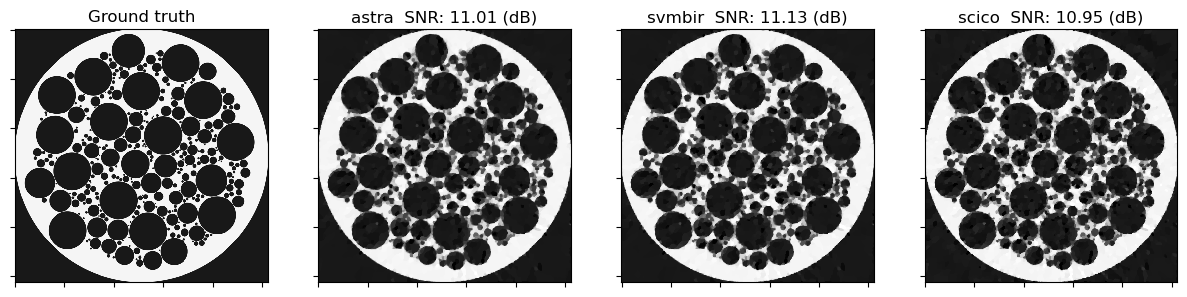

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=4, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
for n, p in enumerate(projectors.keys()):
    plot.imview(
        x_rec[p],
        title="%s  SNR: %.2f (dB)" % (p, metric.snr(x_gt, x_rec[p])),
        fig=fig,
        ax=ax[n + 1],
    )
for ax in ax:
    ax.get_images()[0].set_clim(-0.1, 1.1)
fig.show()